## 1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

### Выбрана сверточная нейронная сеть и датасет oxford_flowers102

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# keras.losses.SparseCategoricalCrossentropy()
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
# tensorflow.keras.metrics.accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import shap

In [4]:
ds_name = 'oxford_flowers102'
# splits = ['test', 'validation', 'train']
splits = ['train[:30%]','test[:10%]']

dataset, info = tfds.load(ds_name, split = splits, with_info=True) #, as_supervised=True)

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [6]:
def normalize_c(input_image, label):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #label -= 1
  return input_image, label

In [7]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128))
  label = datapoint['label']

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)


  input_image, label = normalize_c(input_image, label)

  return input_image, label

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = label = datapoint['label']

  input_image, label = normalize_c(input_image, label)

  return input_image, label 

In [8]:
dataset[0]

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64}>

In [9]:
(train_examples, test_examples) = dataset

In [10]:
train = train_examples.map(load_image_train)
test = test_examples.map(load_image_test)

In [11]:
num_classes = info.features['label'].num_classes

print(f"Number of flower types {num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

# print('Flower types full list:')
classes = info.features['label'].names
print(info.features['label'].names)

Number of flower types 102
Number of training examples: 306
Number of test examples: 615

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargoniu

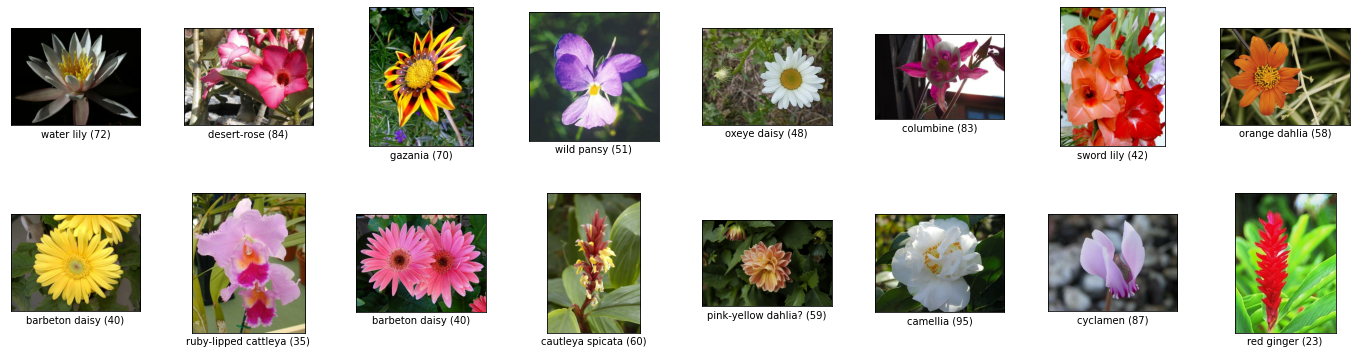

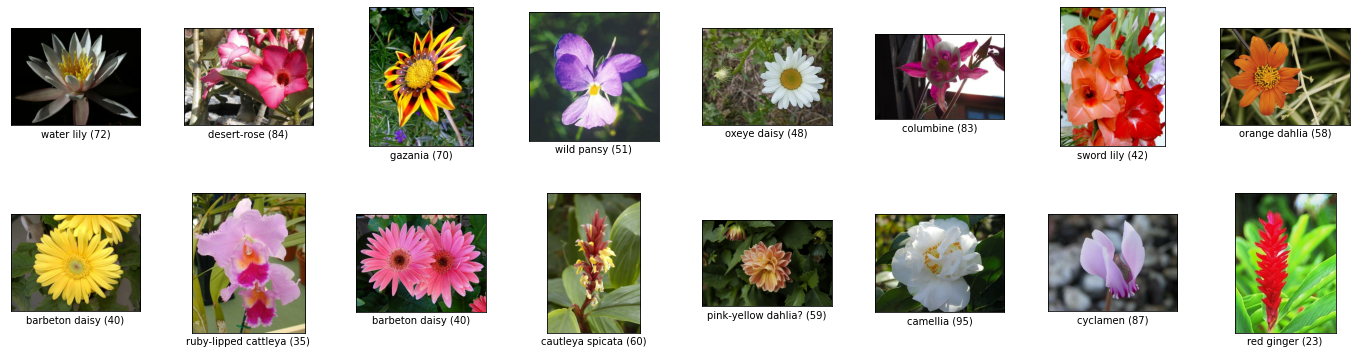

In [12]:
tfds.show_examples(train_examples, info, rows=2, cols=8)

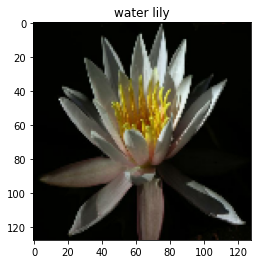

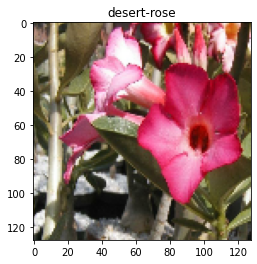

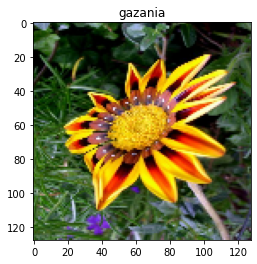

In [13]:
for image, label in train.take(3):
  sample_image, sample_label = image, label
  plt.imshow(sample_image.numpy()[:,:,:])
  plt.title(classes[sample_label.numpy()])
  plt.show()

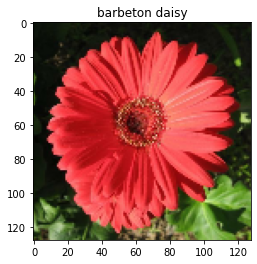

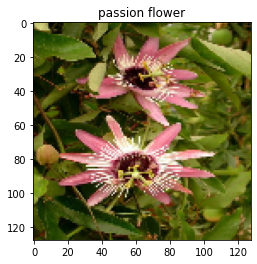

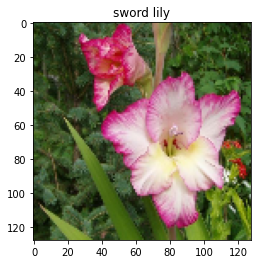

In [14]:
for image, label in test.take(3):
  sample_image, sample_label = image, label
  plt.imshow(sample_image.numpy()[:,:,:])
  plt.title(classes[sample_label.numpy()])
  plt.show()

### Соберем сеть как на занятии

In [15]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [16]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train.batch(BATCH_SIZE)

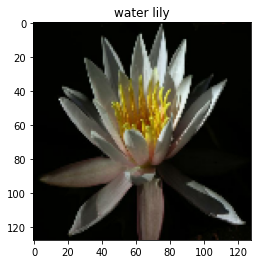

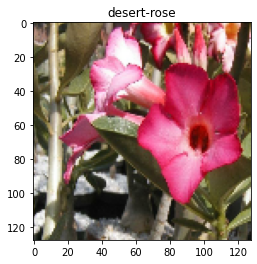

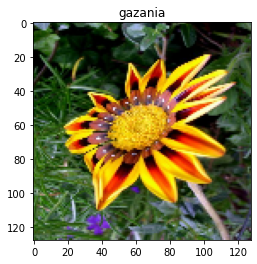

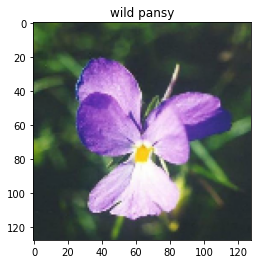

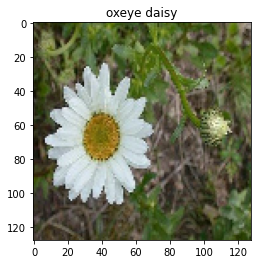

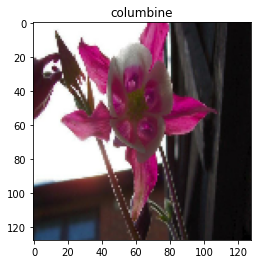

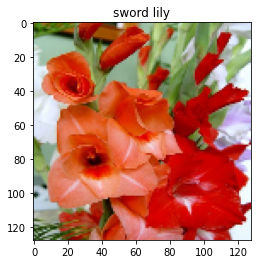

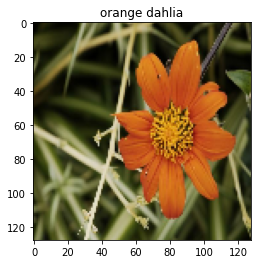

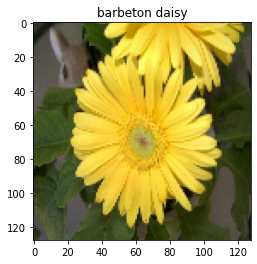

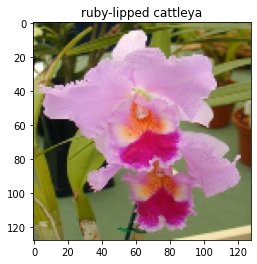

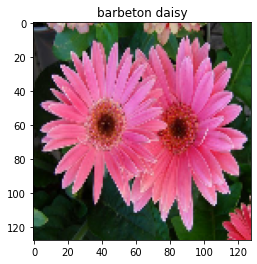

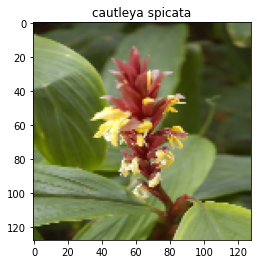

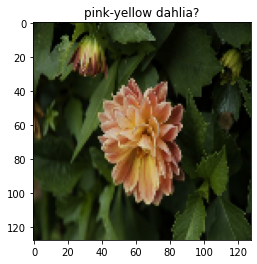

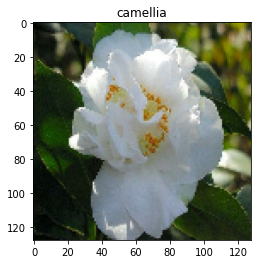

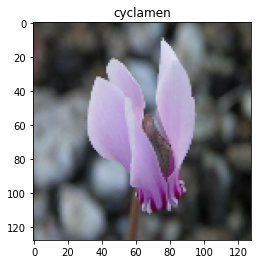

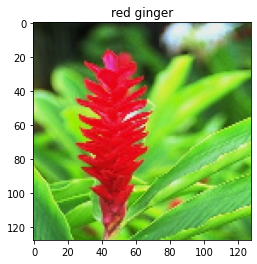

In [17]:
for image, label in train_dataset.take(1):
  
  sample_image, sample_label = image, label
  for i in range(BATCH_SIZE):
    plt.imshow(sample_image.numpy()[i,:,:,:])
    plt.title(classes[sample_label.numpy()[i]])
    plt.show()

### Аугментация

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=90, # очень много - это для демнонстрации
        width_shift_range=0.5,  # очень много - это для демнонстрации
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [19]:
g = tfds.as_numpy((train_dataset.take(10)))
for x,y in g:
  datagen.fit(x)

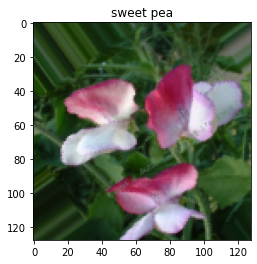

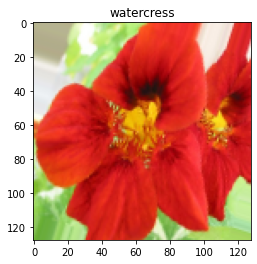

In [20]:
N=1
for image,label in datagen.flow(x,y, batch_size=2):
    for i in range(2):
      plt.imshow(image[i,:,:,:])
      plt.title(classes[label[i]])
      plt.show()
    break

In [21]:
image_size = (image.shape[1], image.shape[2], image.shape[3])
name='flower_model'

In [22]:
# конфигурирование слоев нейросети

model = Sequential(name=name)

model.add(Conv2D(32, (3, 3), padding='same', strides=2, input_shape=image_size))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "flower_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)       

In [24]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE, verbose=0)

In [26]:
# сохранение модели и весов
save_dir = '/home/mitko/Projects/Neural_networks/lesson8'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, name)
model.save(model_path)
print('Cохранить обученную модель как %s ' % model_path)

INFO:tensorflow:Assets written to: /home/mitko/Projects/Neural_networks/lesson8/flower_model/assets


INFO:tensorflow:Assets written to: /home/mitko/Projects/Neural_networks/lesson8/flower_model/assets


Cохранить обученную модель как /home/mitko/Projects/Neural_networks/lesson8/flower_model 


In [27]:
# print(history.history)

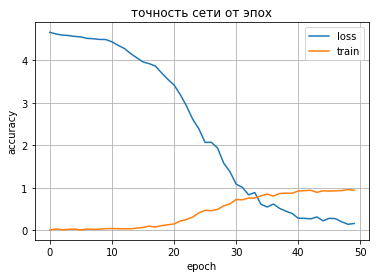

In [28]:
plt.plot(history.history['loss'] ,label='loss')
plt.plot(history.history['accuracy'] ,label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('точность сети от эпох')
plt.grid()
plt.show()

### Оценка обучения

### Вообще не поняла, как работает shap_value, потому что возникает ошибка "AttributeError: module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'"

In [29]:
# берем примеров для оценки

# background = x_test[np.random.choice(x_test.shape[0], 10, replace=False)]

# объясняем через  model наши   images
# e = shap.DeepExplainer(model, background)
# можно подать прямо в модель
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

In [30]:
# shap_values = e.shap_values(x_test[:1])

In [31]:
# i_image  = 0
# shap.image_plot(shap_values[y_label[i_image]], x_test[i_image:i_image+1])

In [32]:
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(x_test[1:5])

# # plot 
# shap.image_plot(shap_values, x_test[1:5])

### Проверка работы обученной модели

Сделаем предикт для примеров тестов

[72 84 70 51 48 83 42 58 40 35 40 60 59 95 87 23]
true label - 58
predicted label - 58


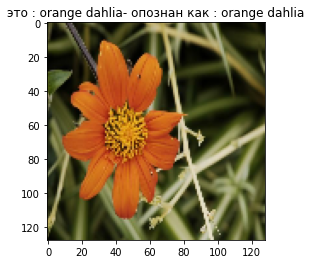

true label - 40
predicted label - 40


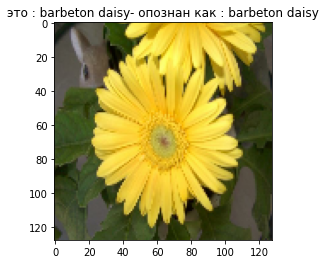

true label - 35
predicted label - 35


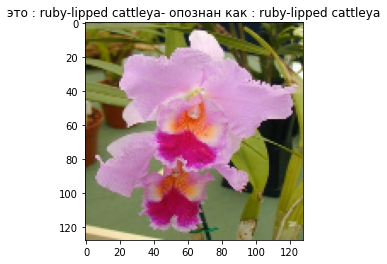

In [33]:
S = 7
N = 10
for image, label in train_dataset.take(1):
    
    image, label = image.numpy(), label.numpy()
    print(label)
    
    for i in range(S, N):
        y_p=model.predict(image[i:i+1][:,:,:])
#         print(y_p)
        y_t = label[i:i+1]
        print(f'true label - {y_t[0]}')
        y_i = np.argmax(y_p, axis = 1)
        print(f'predicted label - {y_i[0]}')
        plt.imshow(image[i][:,:,:])
        plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
        plt.show()

## 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 

</h> Для анализа выбрана Модель машины неустойчивых состояний (liquid state machines, LSM).
Работа данной нейронной сеть очень похожа на работу нейронов мозга. Нейрон возбуждается от сигналов, поступающих от соседних нейронов, но функция активации срабатывает только при достижении порогового значения. Далее нейрон разряжается, передавая накопленную информацию дальше, и остается в состоянии покоя заданное количество времени и не воспринимает сигналы. Проще говоря, при обновлении нейрона его значение не становится равным сумме соседей, а прибавляется само к себе, и при достижении порога сообщается другим нейронам. Кроме того, сигмоидная активация заменена пороговой функцией.
Структура машины неустойчивых состояний представляет собой сеть из  двух  составляющих:  резервуара  в  форме  импульсной рекурентной нейронной сети (РНС) и блока считывателей.
Тип: последовательность -> последовательность.</h>

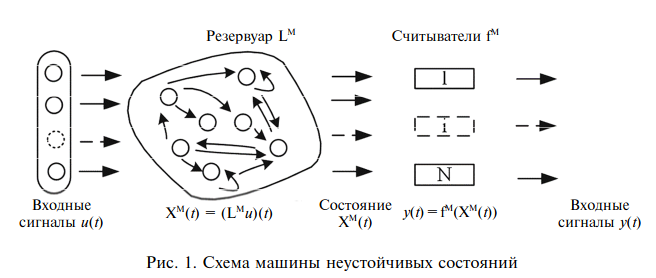

In [3]:
from IPython.display import Image
Image("LSM.png")

</h>Для импульсной РНС задается структура, определяемая количеством нейронов, средним радиусом связности, процентом связей от входов к РНС, плотностью связей, силой (весами) внутренних и внешних связей, соотношением числа подавляющих/возбуждающих нейронов и уровнем шума, типом элементов и типом связей. В качестве элементов могут использоваться простые модели типа нейрона интегрирования возбуждения (IaF) и Ижикевича, а также детальные модели Ходжкина—Хаксли, Морриса—Лекара, Фитцху—Нагумо.

Резервуар формируется таким образом, чтобы для похожих входных сигналов это состояние было похожим, а для разных – разным. Это происходит случайным образом, что исключает необходимость обучения сети резервуара.

Считыватели, в зависимости от решаемой задачи могут быть представлены по-разному. По выполняемой функции все считыватели могут выполнять задачи предобработки выходного сигнала РНС (сокращение размерности, преобразование информации из импульсной формы в непрерывную, нормализация), анализ выходного сигнала РНС (определение типа динамики, вычисление различных показателей) или решение конечной задачи (классификация, регрессия, кластеризация).

Для классификации, в целях визуализации процесса, используется сжатие по алгоритму PCA до двух главных компонент и наивный Байесовский классификатор.

В зависимости от поставленной задачи, необходимо тщательно подбирать элементы, из которых будет состоять сеть. При сколь угодно близких начальных состояниях траектории будут расходиться, если не установлено ограничение. При этом система будет содержать большое колисество информации, которую нелься извлечь.

Данная архитектура используется для распознавания динамических образов. Встречались примеры анализа текста, ЭКГ, эконометрических показателей и др.


Плюсы: исследование динамических систем, большие вычисления.
Минусы: сложности при выборе начального состояния и структуры резервуара, неэффективность использования существующих показателей динамических систем для анализа режимов функционирования даже для простых случаев.
</h>

Использовано:

Научнотехнические ведомости СПбГПУ, Том 11, No 4, 2018  Информатика. Телекоммуникации. Управление 

Научно-технические ведомости СПбГПУ 4' (176) 2013
Информатика. Телекоммуникации. Управление